# Trips vs Staying  at home


Hypothesis:

Trips ~ [number of people staying home]




Create table for each metro area
```
county FIPs, day, trips, avg trips, stay home users, avg stay home users
```
where
- tips calculated by user county  residence rather than trip occurance
- trips is the total number of stays occuring outside user personal area
- avg trips is trips for county divided by county panel size
- stay home users = (county panel size - distinct panel users with trip that day)
- avg stay home users: (county stay home users)/(county panel size)


Plot the data (for each metro area)
- avg trips vs avg stay home users

Run regression:

avg trips = a x [avg stay home users]^b

hypothesis: b ~ 1

In [13]:
import datetime
import math
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

datapath = '/data/covid/'

FIPS = 'county FIPS'
DAY = 'day'
TRIPS = 'trips'
AVG_TRIPS = 'avg trips'
STAY_HOME_USERS = 'stay home users'
AVG_STAY_HOME_USERS = 'avg stay home users'


date_fmt = '%Y-%m-%d'


%config InlineBackend.figure_format = 'retina'

In [2]:
metro_area_to_id = {
    'New York':35620,
    'Seattle':42660,
    'Dallas':19100,
    'Washington':47900,
    'Houston':26420,
    'Chicago':16980,
    'Miami':33100,
    'LA':31080,
    'Boston':14460,
    'San Francisco':41860,
    'Philadelphia':37980,
}

In [5]:
use_metros = [
    'Boston',
    'Dallas',
    'Seattle',
    'Washington',
    'New York',
    'Miami',
    'LA',
]

In [3]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)

start_dt = datetime.date(2020, 2, 17)
end_dt = datetime.date(2020, 5, 22)

dates =  []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime(date_fmt))

In [15]:
GEOID = 'GEOID'
def get_panel_user_county_fips(area):
    """Returns series mapping county FIPS to user ID"""
    panel_data_filepath = datapath + str(area) + '/' + 'homes.final.txt'
    panel_df = pd.read_csv(panel_data_filepath)
    panel_df[FIPS] = panel_df[GEOID].apply(lambda x: str(x)[-11:-6])
    return panel_df.set_index('user')[FIPS]

In [52]:

def get_trips_stay_home_users_data(area_id, dates=dates):
    """
    Returns dataframe for area with columns:
    county FIPs, day, trips, avg trips, stay home users, avg stay home users
    
    days are restricted to dates
    data is restricted to area user panel 
    """
    print('handling area: %s' % area_id)
    stays_path = datapath + str(area_id) + '/' + 'p3_output_stays_by_date_clean_personal_area/'
    
    county_df = pd.DataFrame({
        FIPS:[],
        DAY : [],
        TRIPS: [],
        STAY_HOME_USERS: [],
    })
    
    # Get panel users and panel size for each county
    user_fips = get_panel_user_county_fips(area_id)
    panel_users = user_fips.index
    fips_panel_size = user_fips.value_counts()
    

    for date in dates:
        print('handling data for %s' % date)
        try:
            # read stays data
            stays_filepath = stays_path + date + '.csv'
            stays_df = pd.read_csv(stays_filepath)[['perc_personal_area', 'user_id']]
        except Exception as e:
            print('skipping date %s' % date)
            print(e)
            continue
            # raise
        
        # restrict stays data to user panel data where not personal area
        stays_df = stays_df[stays_df['perc_personal_area'] < 1]
        stays_df = stays_df[stays_df['user_id'].isin(panel_users)]
        # attach user home county  FIPS
        stays_df[FIPS] = stays_df['user_id'].map(user_fips)
        # aggregate trips by county FIPS and make day DF mapping FIPS to TRIPS
        county_day_df = stays_df.groupby(FIPS)['user_id'].count().reset_index().rename(columns={'user_id':TRIPS})
        # count and add STAY HOME USERS
        trips_users = stays_df.groupby(FIPS)['user_id'].nunique()
        stay_home_users = fips_panel_size - trips_users
        county_day_df[STAY_HOME_USERS] = county_day_df[FIPS].map(stay_home_users)
        
        county_day_df[DAY] = date
        
        county_df = county_df.append(county_day_df,ignore_index=True)
    
    county_df[AVG_TRIPS] = county_df[TRIPS].astype(float)/county_df[FIPS].map(fips_panel_size).astype(float)
    county_df[AVG_STAY_HOME_USERS] = county_df[STAY_HOME_USERS].astype(float)/county_df[FIPS].map(fips_panel_size).astype(float)
    return county_df


In [53]:
metro_area_to_county_data = {}

In [ ]:
for metro_area in use_metros:
    area_id = metro_area_to_id[metro_area]
    print('\ngetting data for metro area %s (%s)' % (metro_area, area_id))
    df = get_trips_stay_home_users_data(area_id)
    if len(df) < 10:
        print('insufficient data for %s'% metro_area)
        continue
    metro_area_to_county_data[metro_area] = df

In [73]:
def get_county_trips_v_stayhome_filepath(area):
    return datapath + str(area) + '/county_trips_v_stayhome.csv'

save the  data  to file for  easy access later

In [77]:
for metro_area, df in metro_area_to_county_data.items():
    area_id = metro_area_to_id[metro_area]
    fpath = get_county_trips_v_stayhome_filepath(area_id)
    print('saving contacts and trips data for %s (%s) to %s' % (metro_area, area_id, fpath))
    df.to_csv(fpath, index=False)
    print('saved')

Script re-entry point

In [115]:
metro_area_to_county_data = {}
for metro_area in use_metros:
    area_id = metro_area_to_id[metro_area]
    fpath = get_county_trips_v_stayhome_filepath(area_id)
    df = pd.read_csv(fpath)
    df[FIPS] = df[FIPS].astype(str)
    metro_area_to_county_data[metro_area] = df
    print('loaded previously saved data for %s (%s)' % (metro_area, area_id))


loaded previously saved data for Boston (14460)
loaded previously saved data for Dallas (19100)
loaded previously saved data for Seattle (42660)
loaded previously saved data for Washington (47900)
loaded previously saved data for New York (35620)
loaded previously saved data for Miami (33100)
loaded previously saved data for LA (31080)


In [112]:
metro_area_to_county_data.keys()

['Dallas', 'Miami', 'Boston', 'LA', 'Washington', 'New York', 'Seattle']

In [113]:
# There is a problem with data for March 31 - remove it.
bad_date = datetime.date(2020, 3, 31).strftime(date_fmt)
print('removing from data: %s' % bad_date)
for metro_area, df in metro_area_to_county_data.items():
    metro_area_to_county_data[metro_area] = df[df[DAY]!=bad_date]

removing from data: 2020-03-31


In [114]:
df = metro_area_to_county_data['Boston']
df.head(3)

,county FIPS,day,stay home users,trips,avg trips,avg stay home users
0,25009,2020-02-17,11943.0,19305.0,1.031195,0.637947
1,25017,2020-02-17,21986.0,34606.0,1.000318,0.635525
2,25021,2020-02-17,10315.0,15136.0,0.952609,0.649191


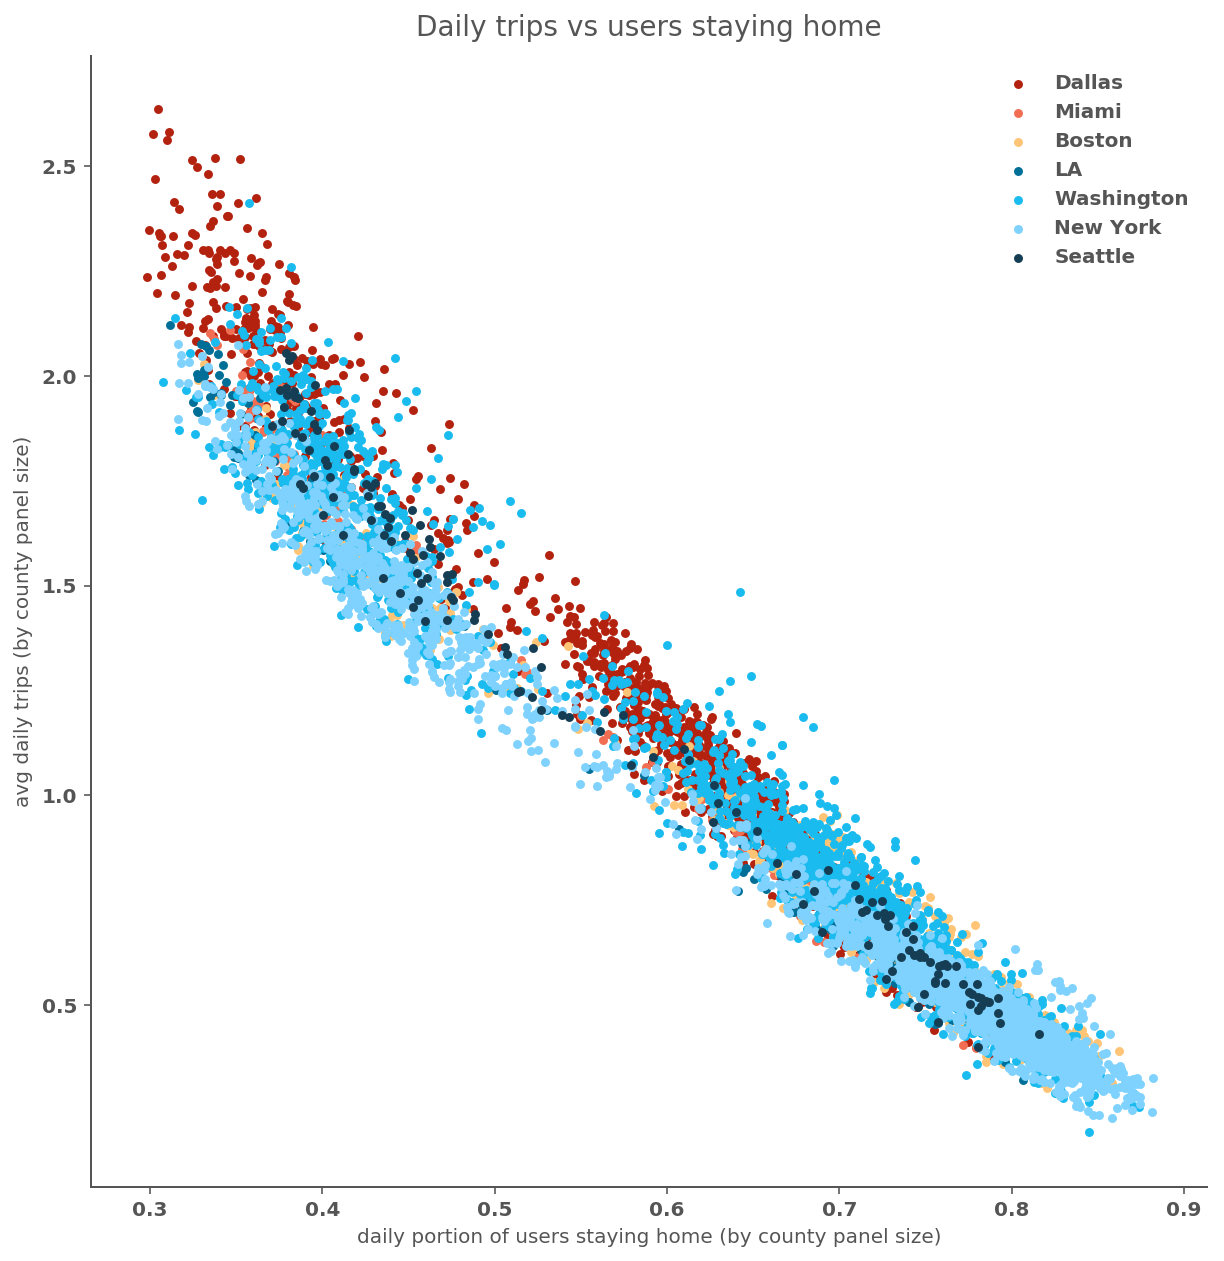

In [93]:
figure, ax = plt.subplots(figsize=(10, 10))
s=12

for metro_area,df in metro_area_to_county_data.items():
    x = df[AVG_STAY_HOME_USERS]
    y = df[AVG_TRIPS]
    ax.scatter(
        x,
        y,
        s=12,
        label=metro_area,
    )
ax.set_xlabel("daily portion of users staying home (by county panel size)")
ax.set_ylabel("avg daily trips (by county panel size)")
title = 'Daily trips vs users staying home'
ax.set_title(title)
plt.legend()
plt.show()

make a giant table with columns
metro area, FIPS, panel size, avg trips, avg stay home users, 


run regression at county level for each metro area

avg trips ~ a x [avg stay home users]^b

regression is run as 

log(avg trips) = a + b x log([avg stay home users])

to make table:

metro area, FIPS, panel size, a, b

In [96]:
METRO_AREA = 'metro area'
PANEL_SIZE = 'panel size'
ALPHA='a'
BETA='b'

In [178]:
def run_regression(df):
    # avg trips = a x (avg stay home users)^b
    # but a is negative
    # log(avg trips) = log(a) + b x log(avg stay home users)
    log_avg_trips=np.log(df[AVG_TRIPS])
    inverted_log_avg_stay_home_users = np.log(1-df[AVG_STAY_HOME_USERS])
    y = log_avg_trips
    x = inverted_log_avg_stay_home_users

    b, log_a_inverted, r_value, p_value, std_err = stats.linregress(x.values,y.values)
    # print(b, log_a_inverted, r_value, p_value, std_err)
    a = math.exp(log_a_inverted)*(-1)
    r_sq = r_value**2 
    CI_95 = [b - 1.960*std_err, b + 1.960*std_err]
    return a,b,r_sq, CI_95

In [179]:
# run regression at the metro level

metro_records = []
for metro_area,df in metro_area_to_county_data.items():
    area_id = metro_area_to_id[metro_area]
    print('metro area:', metro_area, area_id)
    user_fips = get_panel_user_county_fips(area_id)
    fips_panel_size = len(user_fips)
    metro_fips = user_fips.unique()
    a,b,r_sq, CI_95 = run_regression(df)
    regression_dict = {
        METRO_AREA:metro_area,
        PANEL_SIZE: fips_panel_size,
        ALPHA: a,
        BETA: b,
    }
    metro_records += [regression_dict]

metro_regression_results_df = pd.DataFrame(metro_records)
metro_regression_results_df.head()  

('metro area:', 'Dallas', 19100)
('metro area:', 'Miami', 33100)
('metro area:', 'Boston', 14460)
('metro area:', 'LA', 31080)
('metro area:', 'Washington', 47900)
('metro area:', 'New York', 35620)
('metro area:', 'Seattle', 42660)


,a,b,metro area,panel size
0,-4.012012,1.383029,Dallas,345711
1,-3.441003,1.295641,Miami,214833
2,-3.182772,1.209132,Boston,110284
3,-3.346196,1.311274,LA,322284
4,-3.437408,1.254919,Washington,162145


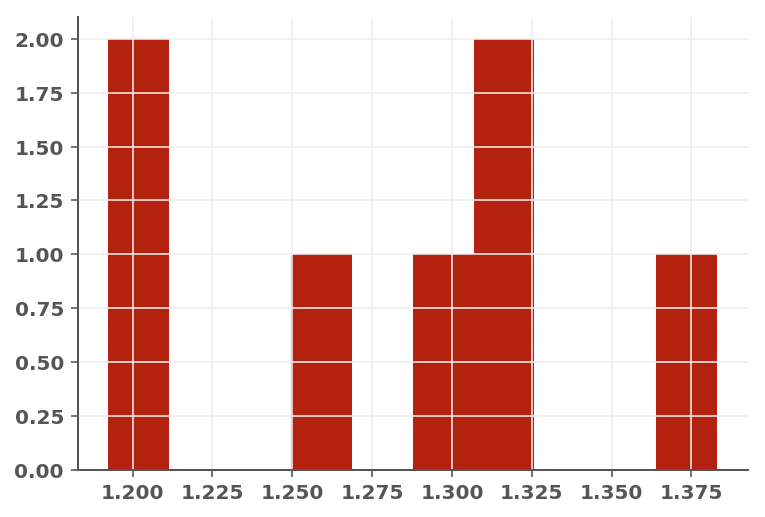

In [210]:
metro_regression_results_df[BETA].hist()

In [180]:
fips_records = []
for metro_area,df in metro_area_to_county_data.items():
    area_id = metro_area_to_id[metro_area]
    print('metro area:', metro_area, area_id)
    user_fips = get_panel_user_county_fips(area_id)
    fips_panel_size_dict = user_fips.value_counts().to_dict()
    metro_fips = user_fips.unique()
    for f in metro_fips:
        f_df = df[df[FIPS]==f]
        a,b,r_sq, CI_95 = run_regression(f_df)
        county_regression_dict = {
            METRO_AREA:metro_area,
            FIPS:f,
            PANEL_SIZE: fips_panel_size_dict[f],
            ALPHA: a,
            BETA: b,
        }
        fips_records += [county_regression_dict]
        

('metro area:', 'Dallas', 19100)
('metro area:', 'Miami', 33100)
('metro area:', 'Boston', 14460)
('metro area:', 'LA', 31080)
('metro area:', 'Washington', 47900)
('metro area:', 'New York', 35620)
('metro area:', 'Seattle', 42660)


In [183]:
metro_county_regression_results_df = pd.DataFrame(fips_records)
metro_county_regression_results_df.head()

,a,b,county FIPS,metro area,panel size
0,-3.489714,1.314523,48121,Dallas,52067
1,-3.795668,1.305018,48113,Dallas,74937
2,-3.782915,1.342715,48439,Dallas,92346
3,-4.195788,1.411705,48251,Dallas,11556
4,-3.437581,1.305011,48085,Dallas,59413


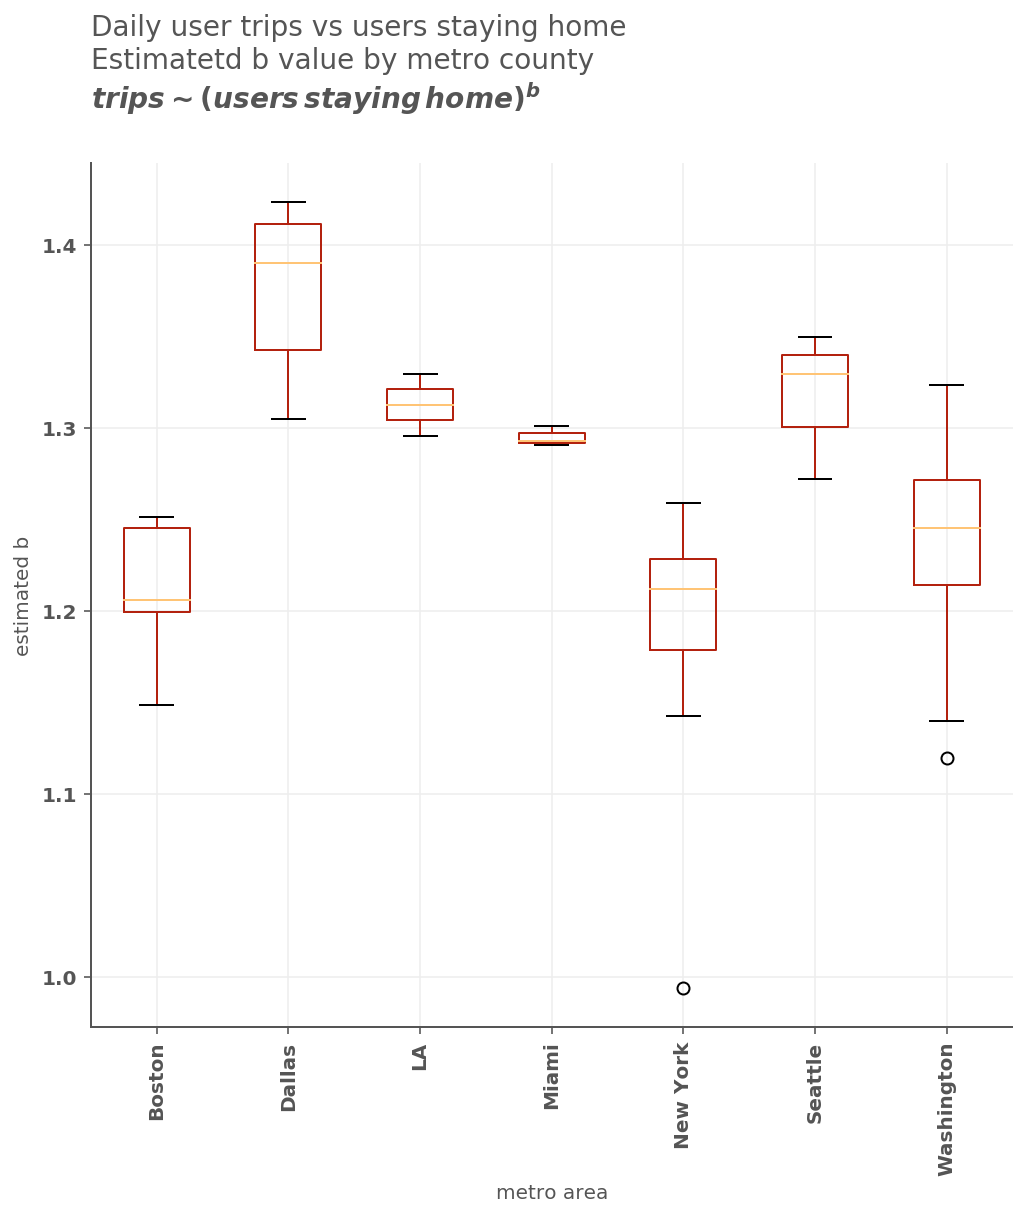

In [211]:
figure, ax = plt.subplots(figsize=(8, 8))

metro_county_regression_results_df.boxplot(column=BETA,by=METRO_AREA,ax=ax)
plt.xticks(rotation=90)
ax.set_ylabel('estimated b')

title = ('Daily user trips vs users staying home\n' + \
         'Estimatetd b value by metro county\n' + \
        '$trips \sim (users\, staying\, home)^b$\n')
plt.title('')
plt.suptitle('')
ax.set_title(title,
             loc='left', # left align
             # fontdict={'fontsize':16},
            )
plt.show()